# Decision Tree Classifier for SE Data with Fridge Location Labels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler
from sklearn import tree

In [2]:
dataFrame = pd.read_csv("Dataset.csv")

In [3]:
fullfeaturelist = ['nei_final_simple','walk_score','transit_score','bike_score','population',
           'population_density','household_income','marital_status_married','marital_status_separated_divorce',
           'marital_status_widowed','marital_status_never_married','white_popl',
            'hispanic_popl','black_popl','asian_popl','mixed_popl','other_popl','food_stamps_total',
            'educational_attainment_no_hs','educational_attainment_bachelors','educational_attainment_very_advanced_degrees',
            'household_type_married_count', 'household_type_single_female_count',
            'household_type_single_male_count','household_type_one_person_count',
            'household_type_other_non_family_count','household_type_with_children','Age_0_to_17','Age_18_to_21',
            'Age_22_to_29','Age_30_to_39','Age_40_to_49','Age_50_to_59','Age_60_to_69','Age_70_to_79','Age_80_older']

# A list with every feature name but neighborhood titles in it.
featurelist = fullfeaturelist[1:]

# A new dataframe after removing job sector data since much of this is missing across many neighborhoods.
dfFull = dataFrame[fullfeaturelist]

# Taking out Pastures Neighborhood because of large lack of data.
df = pd.DataFrame(dfFull[dfFull['nei_final_simple']!= 'Pastures'],columns = fullfeaturelist)
# Taking out West End Neighborhood because of large lack of data.
df = pd.DataFrame(df[df['nei_final_simple'] != 'West End'],columns = fullfeaturelist)
df.reset_index(drop = True, inplace=True)

## Scaling The Dataframe

In [4]:
scaler = MaxAbsScaler()
scaler.fit(df[featurelist])
scaledData = scaler.transform(df[featurelist])
dfScaled = pd.DataFrame(scaledData,columns=featurelist)
dfScaled['nei_final_simple']=df['nei_final_simple']

## Inputting 1930s HOLC Grades (Future Work)

In [5]:
df.loc[:,'holc_grade'] = pd.Series(np.array([3,1,4,0,4,4,1,4,4,1,3,4,3,0,1,4,2,2,1,2,3,3,0,3,3,0]),index=df.index)
dfScaled.loc[:,'holc_grade'] = pd.Series(np.array([3,1,4,0,4,4,1,4,4,1,3,4,3,0,1,4,2,2,1,2,3,3,0,3,3,0]),index=dfScaled.index)

## Inputting Fridge Location Labels

In [6]:
df.loc[:,'fridge_count'] = pd.Series(np.array([1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0]),index=df.index)
dfScaled.loc[:,'fridge_count'] = pd.Series(np.array([1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0]),index=dfScaled.index)

## Creating/Testing One Decision Tree for Accuracy 

In [7]:
trainFood, testFood = train_test_split(df, test_size = 0.2,random_state = 0)

In [8]:
xTrain, yTrain = trainFood.drop(columns =['nei_final_simple','fridge_count','holc_grade']), trainFood['fridge_count']
xTest, yTest = testFood.drop(columns =['nei_final_simple','fridge_count','holc_grade']), testFood['fridge_count']

In [9]:
clf = tree.DecisionTreeClassifier()

In [10]:
clf = clf.fit(xTrain,yTrain)

[Text(200.88000000000002, 190.26, 'X[0] <= 90.5\ngini = 0.32\nsamples = 20\nvalue = [16, 4]'),
 Text(133.92000000000002, 135.9, 'X[26] <= 108.0\ngini = 0.198\nsamples = 18\nvalue = [16, 2]'),
 Text(66.96000000000001, 81.53999999999999, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(200.88000000000002, 81.53999999999999, 'X[22] <= 131.0\ngini = 0.111\nsamples = 17\nvalue = [16, 1]'),
 Text(133.92000000000002, 27.180000000000007, 'gini = 0.0\nsamples = 16\nvalue = [16, 0]'),
 Text(267.84000000000003, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(267.84000000000003, 135.9, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]')]

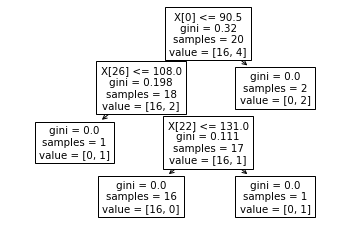

In [11]:
tree.plot_tree(clf)

In [12]:
predictions = clf.predict(xTest)
sum([1 if predictions[i] == np.array(yTest)[i] else 0 for i in range(len(predictions))])/len(predictions)

0.3333333333333333

With an accuracy of 33\%, our decision tree classifer didn't perform to well.

## Averaging Decision Tree Accuracies Over N Trials

In [13]:
def DecTreeAccNTrialsFridgeCount(dataframe,N,crit = 'gini'):
    '''A method to construct N decision trees to predict fridge labels.
    This method returns the average accuracy of all the classifiers together.'''
    accuracy = []
    for i in range(N):
        trainFood, testFood = train_test_split(dataframe, test_size = 0.3)
        xTrain, yTrain = trainFood.drop(columns =['nei_final_simple','fridge_count','holc_grade']), trainFood['fridge_count']
        xTest, yTest = testFood.drop(columns =['nei_final_simple','fridge_count','holc_grade']), testFood['fridge_count']
        clf = tree.DecisionTreeClassifier(criterion = crit)
        clf = clf.fit(xTrain,yTrain)
        predictions = clf.predict(xTest)
        accuracy.append(sum([1 if predictions[i] == np.array(yTest)[i] else 0 for i in range(len(predictions))])/len(predictions))
    return sum(accuracy)/len(accuracy)

In [16]:
# The values below are for 10000 trials, but I lowered
# N to 100 for speed of computation.
DecTreeAccNTrialsFridgeCount(df,100,crit = 'gini')

0.6583125

In [17]:
# The values below are for 10000 trials, but I lowered
# N to 100 for speed of computation.
DecTreeAccNTrialsFridgeCount(df,100,crit = 'entropy')

0.643125

Really doesn't look promising.  Especially when our KNN Classifiers do better than this by a good margin.  
- Can we adjust the parameters of the decision tree to obtain better accuracies?
- Can we construct features which a decision tree performs better with?  

Whether Gini or Entropic flavor is used, our decision trees appear to not generalize well at all.  If there's time, I'll fiddle with these in the future.  For now, we have decent results from KNN and will proceed with that.